<a href="https://colab.research.google.com/github/bcdmodelos/qualificacao-modelscode/blob/main/Modelo-GPR/codigo_modelo_gpr_paraiba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise por Regressão por Processos Gaussianos para o estado da Paraíba


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls

drive  sample_data


In [5]:
%cd /content/drive/MyDrive/Notebooks_Doutorado/base-campina/

!ls

/content/drive/MyDrive/Notebooks_Doutorado/base-campina
dataset_Amazonas_usableData.csv
dataset_Bodocongo_usable.csv
dataset_Brasil_usableData.csv
dataset_CampinaGrande_casos_acumulados_usable.csv
dataset_CampinaGrande_casos_diarios_usable.csv
dataset_CampinaGrande_usableData.csv
dataset_Catole_usable.csv
dataset_Malvinas_usable.csv
dataset_Paraiba_usableData.csv
dataset_Pernambuco_usableData.csv


In [7]:
file_path = "./dataset_Paraiba_usableData.csv"
casosParaiba = pd.read_csv(file_path, encoding='latin1')
casosParaiba.head()

,Unnamed: 0,date,totalCases,deaths,suspects,recovered,tests,vaccinated,vaccinated_second,activeCases,newVaccinated,newVaccinated_second
0,280,2020-03-22,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,308,2020-03-23,2,0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,336,2020-03-24,3,0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,364,2020-03-25,5,0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,392,2020-03-26,6,0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dfParaiba  = casosParaiba.iloc[:,[1,2]]
dfParaiba

,date,totalCases
0,2020-03-22,1
1,2020-03-23,2
2,2020-03-24,3
3,2020-03-25,5
4,2020-03-26,6
...,...,...
462,2021-06-27,391811
463,2021-06-28,392926
464,2021-06-29,394709
465,2021-06-30,396442


# Visualização dos Dataset's de número de casos acumulados

Text(0.5, 0, 'Dia')

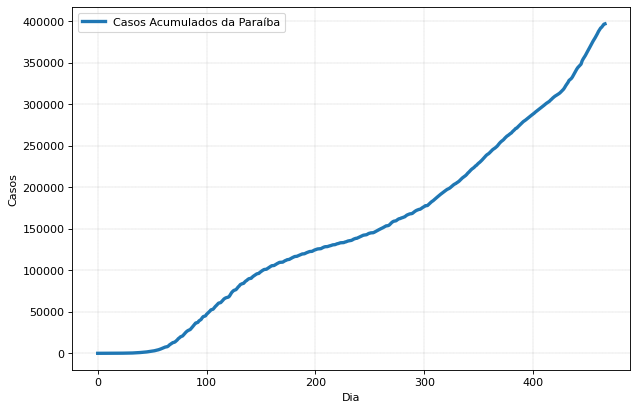

In [10]:
data = np.array(dfParaiba.totalCases.values)
data = data.reshape(-1, 1)

CRdata = data/1000
CRdata  = np.ravel(CRdata)

plt.figure(2, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['Casos Acumulados da Paraíba'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos')
plt.xlabel('Dia')

Dataset de teste

In [11]:
trainL = len(CRdata) - 30

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]

In [12]:
def half_data(data, time):
    half_data = []
    half_time = []
    for i,item in enumerate(data):
        if i%2 == 0:
            half_data.append(item)
            half_time.append(time[i])

    return np.array(half_data), np.array(half_time)

Modelagem

In [13]:
def GPR_Model(CR_tr, t_tr, CR_test, t_test):

    t = np.append(t_tr, t_test).reshape(-1,1)
    CRdata = np.append(CR_tr, CR_test)

    #kernel = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()
    kernel = ConstantKernel()*RBF()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)
    # kernel = RBF()
    # kernel = Matern()

    model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

    model.fit(t_tr, CR_tr)
    print("\nLearned kernel: %s" % model.kernel_)
    params = model.kernel_.get_params()

    R2_tr  = model.score(t_tr, CR_tr)
    R2     = model.score(t, CRdata)
    R2_test = model.score(t_test, CR_test)

    CRpred_tr, sigma_tr = model.predict(t_tr, return_std=True)
    CRpred_test, sigma_test = model.predict(t_test, return_std=True)
    CRpred, sigma   = model.predict(t, return_std=True)

    MSE = np.mean(((CRpred_tr-CR_tr)*1000)**2)
    print("\nMSE: %f" % MSE)
    print("\nSTD: %f" % np.sqrt(MSE))
    print("\nR2 treinamento: %f" % R2_tr)
    print("\nR2 todo intervalo de dados: %f" % R2)
    print("\nR2 de teste: %f" % R2_test)

    return CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata

In [14]:
CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata = GPR_Model(CR_tr, t_tr, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Learned kernel: 0.383**2 * RBF(length_scale=76.1) * DotProduct(sigma_0=6.03e-05) * 1.41**2

MSE: 455661.650847

STD: 675.027148

R2 treinamento: 0.999950

R2 todo intervalo de dados: 0.999670

R2 de teste: 0.857367


In [17]:
def plot_gpr(CRdata, CRpred, sigma, t):
    plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    mpl.style.use('default')
    plt.plot(t, CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados Paraíba')
    plt.axvline(x = t_test[0],linestyle= '--', color = 'black')
    plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)
    plt.fill(np.concatenate([t, t[::-1]]),
            np.concatenate([CRpred*1000 - 1.96000 * 1000*sigma,
                            (CRpred*1000 + 1.96000 * 1000*sigma)[::-1]]),
            alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
    plt.legend(loc='upper left', fontsize = 14)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylabel('Total de casos', fontsize = 14)
    plt.xlabel('dia', fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

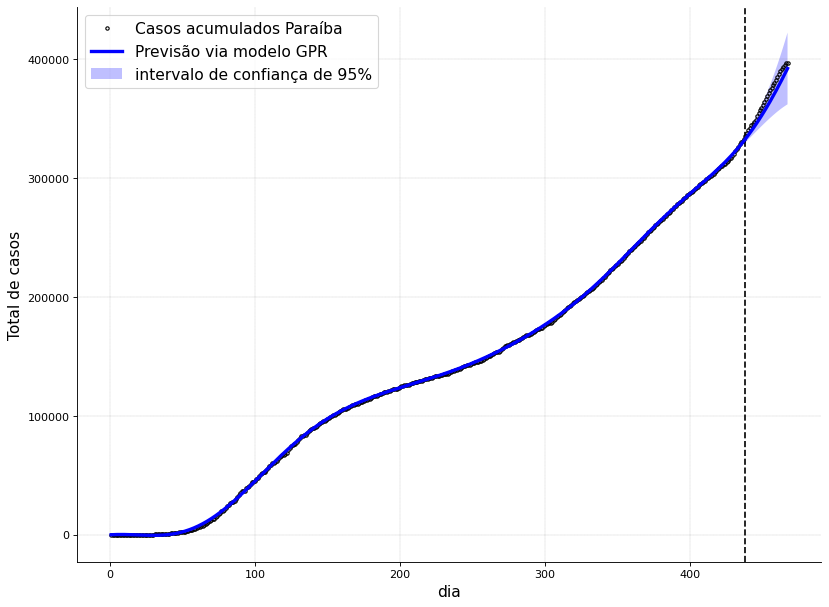

In [18]:
plot_gpr(CRdata, CRpred, sigma, t)

Análise para 50% dos dados

In [19]:
CR_tr_half,t_tr_half = half_data(CR_tr, t_tr)

In [20]:
CRpred_tr_half, sigma_tr_half, CRpred_test_half, sigma_test_half, CRpred_half, sigma_half, t_half, CRdata_half = GPR_Model(CR_tr_half, t_tr_half, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.0732**2 * RBF(length_scale=89.5) * DotProduct(sigma_0=0.000156) * 7.94**2

MSE: 706700.181073

STD: 840.654615

R2 treinamento: 0.999923

R2 todo intervalo de dados: 0.998262

R2 de teste: 0.486855


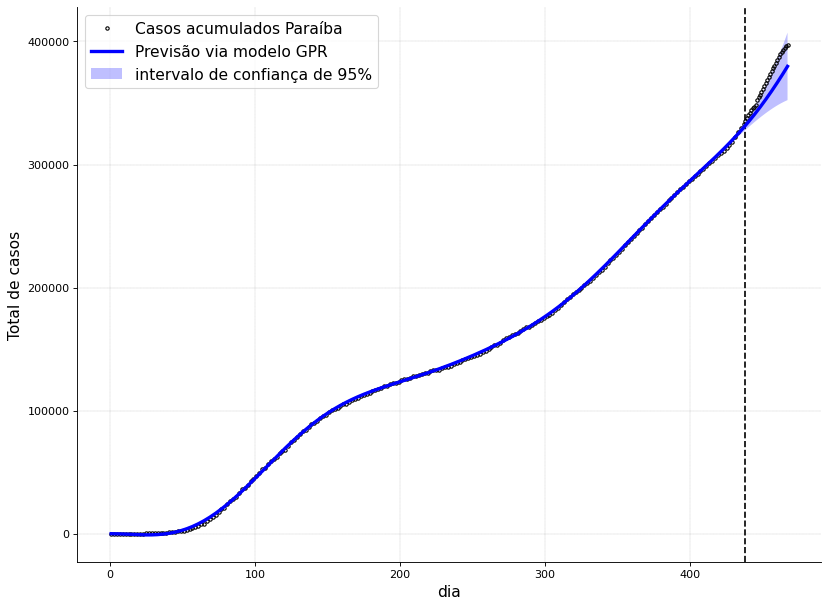

In [21]:
plot_gpr(CRdata_half, CRpred_half, sigma_half, t_half)

Análise para 1/4 dos dados

In [22]:
CR_tr_quarter,t_tr_quarter = half_data(CR_tr_half, t_tr_half)
CRpred_tr_quarter, sigma_tr_quarter, CRpred_test_quarter, sigma_test_quarter, CRpred_quarter, sigma_quarter, t_quarter, CRdata_quarter = GPR_Model(CR_tr_quarter, t_tr_quarter, CR_test, t_test)


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Learned kernel: 0.373**2 * RBF(length_scale=89) * DotProduct(sigma_0=1.08e-05) * 1.41**2

MSE: 900928.237943

STD: 949.172396

R2 treinamento: 0.999902

R2 todo intervalo de dados: 0.996047

R2 de teste: 0.208658


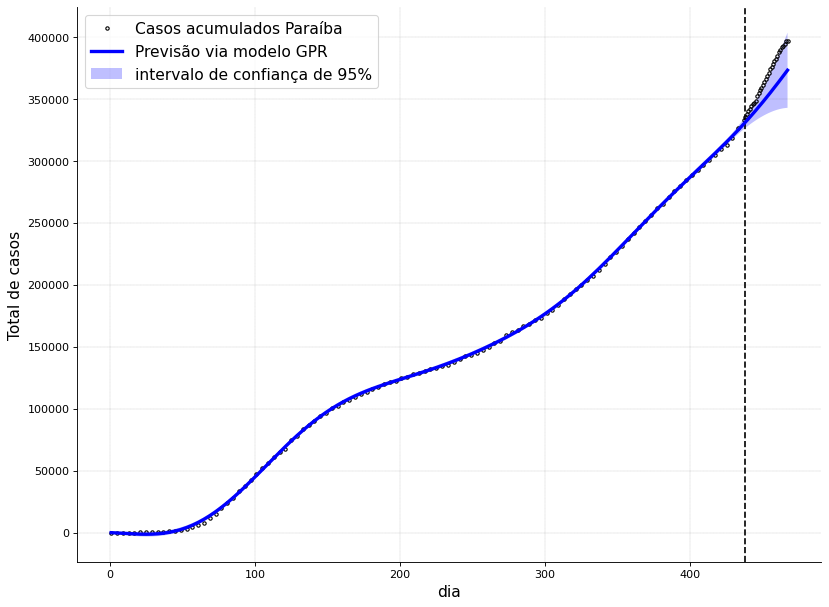

In [23]:
plot_gpr(CRdata_quarter, CRpred_quarter, sigma_quarter, t_quarter)